<a href="https://colab.research.google.com/github/graphtrek/stockforecast/blob/main/graphtrek_06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [140]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MAE
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from datetime import datetime, timedelta
import pandas as pd
import os, time
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from keras.preprocessing.sequence import TimeseriesGenerator

In [141]:
ticker = "SPY"
look_back = 5 #  number of past days we want to use to predict 1 day in the future.
max_data_size = 730 # ~2 years
split_percent = 0.90 # use 90% of the data  for train
print_level = 'DEBUG'
model_file_path = '/content/drive/MyDrive/models/'+ticker+'_06.h5'
nr_of_features = 1
look_forward = 1
epochs = 50
learning_rate=0.0001
num_prediction = look_back
use_values = False
#np.random.seed(42)

In [142]:
url = 'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol='+ticker+'&outputsize=full&apikey=3F4URDEKOPLFH25T'
print(url)
stock_api_response = pd.read_json(url)
stock_api_data = stock_api_response['Time Series (Daily)']
#print(stock_api_data)
stock_api_data = stock_api_data.drop(index=['1. Information','2. Symbol','3. Last Refreshed','4. Output Size','5. Time Zone']);

data = []
lstm_data = []
split_coefficient = 1

for key, value in stock_api_data.items():
  date = key
  open = float(value.get('1. open'))
  high = float(value.get('2. high'))
  low = float(value.get('3. low'))
  close = float(value.get('4. close'))
  adjusted_close = float(value.get('5. adjusted close'))
  volume = int(value.get('6. volume'))
  divident = float(value.get('7. dividend amount'))

  if float(value.get('8. split coefficient')) > 1:
    split_coefficient = float(value.get('8. split coefficient'))
    
  open = open / split_coefficient
  high = high /split_coefficient
  close = close / split_coefficient
  low = low / split_coefficient
  
  # features
  lstm_data.append([
    close
  ])

  data.append([
      date,
      close,
      volume,
      high,
      low,
      open,
      divident
      ])

last_date =  str(data[0][0])

if max_data_size < len(data):
  data = np.flip(data[:max_data_size],axis=0)
  lstm_data = np.flip(lstm_data[:max_data_size],axis=0)
else:
  data = np.flip(data,axis=0)
  lstm_data = np.flip(lstm_data,axis=0)

https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol=SPY&outputsize=full&apikey=3F4URDEKOPLFH25T


In [143]:
# Normalised values [0,max_price] as integer and add to the features
if use_values is True:
  values = data[:,2].astype(int)
  max_price = np.amax(lstm_data)

  values_scaled = (max_price*(values - np.min(values))/np.ptp(values)).astype(float)
  lstm_data = np.append(lstm_data, np.expand_dims(values_scaled, axis=1), axis=1)

  if print_level == 'TRACE':
    print('max_price:',max_price)
    print('values:',values[:5])
    print('values_scaled',values_scaled[:5])
    print('lstm_data:',lstm_data[:5])

In [144]:
if print_level == 'TRACE':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('data ===>', 'size:',len(data), 'max_data_size:', max_data_size, 'shape:', data.shape)
  print(data[:look_back])
  print('lstm_data ===>', 'size:',len(lstm_data), 'max_data_size:', max_data_size, 'shape:', lstm_data.shape)
  print(lstm_data[:look_back])

In [145]:
df = pd.DataFrame(data,columns=['Date','Close','Volume','High','Low','Open','Divident'])

df['50MA'] = df['Close'].rolling(50).mean()
df['100MA'] = df['Close'].rolling(100).mean()
df['200MA'] = df['Close'].rolling(200).mean()

split = int(split_percent*len(data))
if len(data) - split < look_back:
  split = look_back
split
#df.head()

df_train = df.iloc[:split]
df_test = df.iloc[split:]

lstm_train_data = lstm_data[:split]
lstm_test_data = lstm_data[split:]

In [146]:
if print_level == 'TRACE':
  print('df_test ===>', 'size:',len(df_test),'shape:', df_test.shape)
  print(df_test.head())

  print('df_train ===>', 'size:',len(df_train),'shape:', df_train.shape)
  print(df_train.head())

  print('lstm_test_data ===>', 'size:',len(lstm_test_data), 'shape:', lstm_test_data.shape)
  print(lstm_test_data[:2*(look_back + 1)])

  print('lstm_train_data ===>', 'size:',len(lstm_train_data), 'shape:', lstm_train_data.shape)
  print(lstm_train_data[:2*(look_back + 1)])

In [147]:
np.set_printoptions(formatter={'float': '{: 0.12f}'.format})

#print(lstm_data[-1])
#min_data = np.amin(lstm_data)
#mean_data = np.mean(lstm_data)
#max_data = np.amax(lstm_data) * 1.2

#print('mean:', mean_data, 'max:', max_data, 'min:',0)
#scaler_data = np.append(lstm_data,[
#    max_data,
#    max_data,
#    max_data,
#    max_data,
#    max_data
#  ])

#print(scaler_data[-2])

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(lstm_data)

lstm_train_data_scaled = scaler.transform(lstm_train_data)
if print_level == 'DEBUG':
  print(lstm_train_data_scaled[:look_back+1])
  print(lstm_train_data_scaled.shape)

lstm_test_data_scaled = scaler.transform(lstm_test_data)
if print_level == 'DEBUG':
  print(lstm_test_data_scaled[:look_back+1])
  print(lstm_test_data_scaled.shape)

[[ 0.171900126957]
 [ 0.174016081253]
 [ 0.174269995768]
 [ 0.179898434194]
 [ 0.179517562421]
 [ 0.158781210326]]
(657, 1)
[[ 0.880702496826]
 [ 0.895471857808]
 [ 0.899322894625]
 [ 0.918281845112]
 [ 0.922852306390]
 [ 0.914346170123]]
(73, 1)


In [148]:
train_generator = TimeseriesGenerator(lstm_train_data_scaled, lstm_train_data_scaled, length=look_back, batch_size=look_forward)

if print_level == 'TRACE':
  print('Samples: %d' % len(train_generator))
  # print each sample
  for i in range(2):
    x, y = train_generator[i]
    print('%s => %s' % (x, y))

In [149]:
model = None
try:
  model = keras.models.load_model(model_file_path)
  modified = os.path.getmtime(model_file_path)

  print(pd.to_datetime(last_date).date() - datetime.fromtimestamp(modified).date() )
  print('Loaded', model_file_path , ' model train date:',datetime.fromtimestamp(modified).date() , 'last date:', last_date)
except:
  model = None
  print('Model ' + model_file_path + ' does not exists.')

Model /content/drive/MyDrive/models/SPY_06.h5 does not exists.


Model /content/drive/MyDrive/models/SPY_06.h5 compiled.
Saved model /content/drive/MyDrive/models/SPY_06.h5


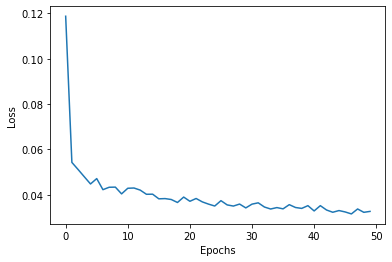

In [150]:
if model is None:
  model = Sequential()
  model.add(LSTM(units=50, activation='tanh', input_shape=(look_back, nr_of_features), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, return_sequences=True, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(LSTM(units=50, activation="tanh"))
  model.add(Dropout(0.2))
  model.add(Dense(nr_of_features))

  model.compile(
      loss=MAE,
      optimizer=Adam(learning_rate=learning_rate),
      metrics=["mae"]
  )
    
  #model.summary()
  print('Model ' + model_file_path + ' compiled.')

  modelo = model.fit(train_generator, epochs=epochs, verbose=0)
  
  model.save(model_file_path)
  print('Saved model ' + model_file_path)

  if print_level == 'DEBUG':
    plt.plot(modelo.history['loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

In [151]:
test_generator = TimeseriesGenerator(lstm_test_data_scaled, lstm_test_data_scaled, length=look_back, batch_size=look_forward)

print('Samples: %d' % len(test_generator))
# print each sample
if print_level == 'TRACE':
  for i in range(2):
    x, y = test_generator[i]
    print('%s => %s' % (x, y))

Samples: 68


In [152]:
#Make prediction
prediction_scaled = model.predict(test_generator)

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.12f}'.format})
  print(prediction_scaled[:5])

prediction = scaler.inverse_transform(prediction_scaled)
pred_prices = prediction[:,0]

if print_level == 'DEBUG':
  np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
  print('prediction shape:',prediction.shape)

  for x in range(look_back + 1):
    print('pred:',prediction[x], 'test:', lstm_test_data[x])


[[ 0.914137840271]
 [ 0.924570143223]
 [ 0.931529283524]
 [ 0.939211845398]
 [ 0.938964128494]]
prediction shape: (68, 1)
pred: [ 438.96] test: [ 431.06]
pred: [ 441.43] test: [ 434.55]
pred: [ 443.07] test: [ 435.46]
pred: [ 444.89] test: [ 439.94]
pred: [ 444.83] test: [ 441.02]
pred: [ 444.08] test: [ 439.01]


In [153]:
def predict(num_prediction, model):
    prediction_list = lstm_test_data_scaled[-look_back:]
    print('prediction_list',prediction_list)
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        #print(x)
        x = x.reshape((1, look_back, nr_of_features))
        out = model.predict(x)
        #print(x,out) 
        prediction_list = np.append(prediction_list, out, axis=0)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(last_date,num_prediction):
    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1,freq=us_bd).tolist()
    return prediction_dates

forecast_scaled = predict(num_prediction, model)
#print(forecast_scaled)
forecast_dates = predict_dates(df['Date'].values[-1],num_prediction)

forecast = scaler.inverse_transform(forecast_scaled.reshape((-1,nr_of_features)))
if nr_of_features == 1:
   forecast_prices = forecast.reshape((-1))
else:
  forecast_prices = forecast[0::nr_of_features].reshape((-1))
print('forecast:',forecast)
print('forecast_prices',forecast_prices)

prediction_list [[ 0.98]
 [ 0.99]
 [ 0.98]
 [ 1.00]
 [ 1.00]]
forecast: [[ 459.25]
 [ 459.38]
 [ 459.76]
 [ 460.30]
 [ 462.30]
 [ 462.83]]
forecast_prices [ 459.25  459.38  459.76  460.30  462.30  462.83]


In [154]:
trace1 = go.Candlestick(
    x = df_train['Date'],
    open = df_train['Open'],
    high = df_train['High'],
    low = df_train['Low'],
    close = df_train['Close'],
    name = 'Train'
)

trace2 = go.Candlestick(
    x = df_test['Date'],
    open = df_test['Open'],
    high = df_test['High'],
    low = df_test['Low'],
    close = df_test['Close'],
    increasing={'line': {'color': 'lightblue'}},
    decreasing={'line': {'color': 'purple'}},    
    name ='Test'
)

trace3 = go.Scatter(
    x = df_test['Date'],
    y = pred_prices,
    name ='Test'
)

trace4 = go.Scatter(
    x = forecast_dates,
    y = forecast_prices,
    name ='Forecast'
)

trace5 = go.Scatter(
    x = df['Date'],
    y = df['50MA'],
    mode='lines',
    name ='50MA'
)

trace6 = go.Scatter(
    x = df['Date'],
    y = df['100MA'],
    mode='lines',
    name ='100MA'
)

trace7 = go.Scatter(
    x = df['Date'],
    y = df['200MA'],
    mode='lines',
    name ='200MA'
)

#'Date','Close','Volume','High','Low','Open','Divident'
open_price =  str(data[-1][5])
low_price =  str(data[-1][3])
high_price =  str(data[-1][4])
close_price =  str(data[-1][1])

layout = go.Layout(
    title = ticker + ' Date:' + last_date + ' Open:' + open_price + ' High:' + high_price + ' Low:' + low_price + ' Close:' + close_price,
    xaxis = {'title' : "Dates"},
    yaxis = {'title' : "Close Price ($)"},
    height = 450
)

fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5, trace6, trace7], layout=layout)

fig.update_yaxes(showspikes=True, spikemode='across', spikesnap='cursor',spikedash='dash')
fig.update_xaxes(showspikes=True, spikemode='across', spikesnap='cursor', spikedash='dash')
fig.update_layout(xaxis_rangeslider_visible=False)
config = dict({'scrollZoom': True})
fig.show(config=config)

fig.write_html('/content/drive/MyDrive/models/charts/'+ticker+ '_06_' + last_date + '_forecast.html')

fig1 = px.bar(
    x=df['Date'], 
    y=df['Volume'], 
    height=250, 
    labels={"x": "Dates","y": "Volume"},
    title=ticker)
fig1.show()